In [2]:
import numpy as np
import scipy.signal
import pandas as pd
import spectrum
import padasip as pa
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def costfunction(X,y,theta):
    m = np.size(y)

    #Cost function in vectorized form
    h = X @ theta
    J = float((1./(2*m)) * (h - y).T @ (h - y));    
    return J;


def gradient_descent(X,y,theta,alpha = 0.0005,num_iters=1000, eps=1e-5, percent=False):
    #Initialisation of useful values 
    m = np.size(y)
    J_history = np.zeros(num_iters)
    theta_0_hist, theta_1_hist = [], [] #For plotting afterwards

    for i in range(num_iters):
        #Cost and intermediate values for each iteration
        J_history[i] = costfunction(X,y,theta)
        theta_0_hist.append(theta[0,0])
        theta_1_hist.append(theta[1,0])
        
        #Grad function in vectorized form
        h = X @ theta
        grad = alpha * (1/m)* (X.T @ (h-y))
        if percent:
            grad *= theta * np.sign(theta)
            # Inject noise if theta is close to zero so it can cross the boundary
            theta[abs(theta) < 0.001] *= -1
        prev_theta = theta
        theta = theta - grad
        
        if np.linalg.norm(theta - prev_theta) < eps:
            break

    return theta,J_history, theta_0_hist, theta_1_hist

def gradient_descent2(X,y,theta, alpha = 0.0005,num_iters=1000, eps=1e-10, percent=False):
    #Initialisation of useful values 
    m = np.size(y)
    J_history = []
    theta_0_hist, theta_1_hist = [], [] #For plotting afterwards
    converged = False
    theta = theta[:,0]
    prev_theta = theta
    for i in range(num_iters):
        #Cost and intermediate values for each iteration
        
        for j in range(m): 
            h = np.dot(X[j], theta**2)
            e = h - y[j]

            #Grad function in vectorized form            
            grad = alpha * e * X[j]
            if percent:
                grad *= theta * np.sign(theta)
                # Inject noise if theta is close to zero so it can cross the boundary
                theta[abs(theta) < 0.001] *= -1
                
            J_history.append(e**2)
            theta_0_hist.append(theta[0])
            theta_1_hist.append(theta[1])
            prev_theta = theta
            theta = theta - grad   # Gradient update     
            if np.linalg.norm(theta - prev_theta) < eps:
                converged = True
                break
        if converged:
            break

    return theta,J_history, theta_0_hist, theta_1_hist

# Compare LMS vs %LMS tracks

(80, 2) (80, 1)


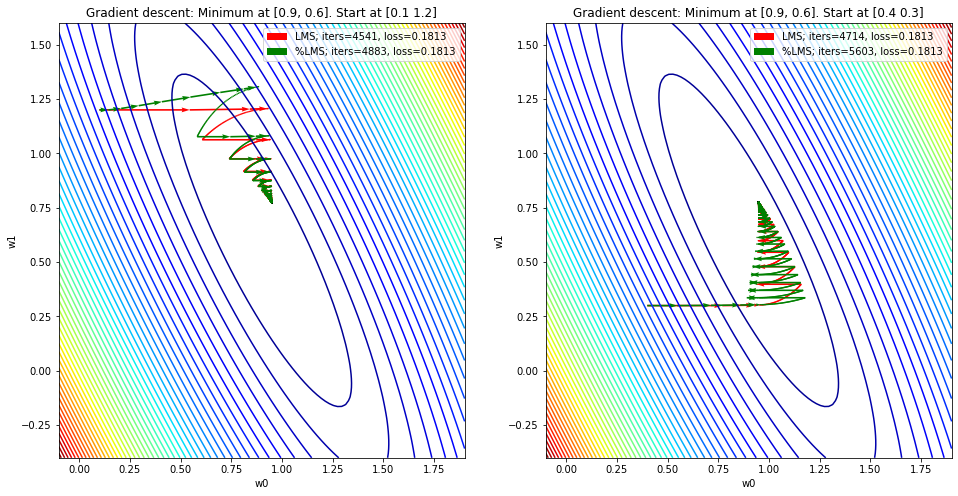

In [3]:
#Creating the dataset (as previously)
x = np.linspace(0,1,80)
w_opt = [0.9, 0.6]
y = w_opt[1]*x + w_opt[0]
y_noise = (y).reshape(-1,1)
X = np.vstack((np.ones(len(x)),x)).T
print(X.shape, y_noise.shape)

#Setup of meshgrid of theta values
delta = 1
T0, T1 = np.meshgrid(np.linspace(w_opt[0]-delta,w_opt[0]+delta,100),np.linspace(w_opt[1]-delta,w_opt[1]+delta,100))

#Computing the cost function for each theta combination
zs = np.array(  [costfunction(X, y_noise.reshape(-1,1),np.array([t0,t1]).reshape(-1,1)) 
                     for t0, t1 in zip(np.ravel(T0), np.ravel(T1)) ] )
#Reshaping the cost values    
Z = zs.reshape(T0.shape)


#Computing the gradient descent
w_inits = [[0.1, 1.2], [0.4, 0.3]]
fig = plt.figure(figsize = (16,8))
for i, w_init in enumerate(w_inits):
    w_init = np.array(w_init).reshape(-1,1)
    theta_result, J_history, theta_0, theta_1 = gradient_descent2(X,y_noise,w_init,alpha = 5e-1,num_iters=2000, eps=1e-10)
    theta_result2, J_history2, theta_02, theta_12 = gradient_descent2(X,y_noise,w_init,alpha = 5e-1,num_iters=2000, eps=1e-10, percent=True)

    loss = np.linalg.norm(theta_result-w_opt)
    loss2 = np.linalg.norm(theta_result2-w_opt)
    
    #Angles needed for quiver plot
    anglesx = np.array(theta_0)[1:] - np.array(theta_0)[:-1]
    anglesy = np.array(theta_1)[1:] - np.array(theta_1)[:-1]

    anglesx2 = np.array(theta_02)[1:] - np.array(theta_02)[:-1]
    anglesy2 = np.array(theta_12)[1:] - np.array(theta_12)[:-1]

    #Contour plot
    plt.subplot(1,2,i+1)
    plt.contour(T0, T1, Z, 50, cmap = 'jet', alpha=1)
    plt.quiver(theta_0[:-1], theta_1[:-1], anglesx, anglesy, scale_units = 'xy', angles = 'xy', scale = 1, color = 'r', alpha = 1, label=
             f'LMS; iters={len(theta_0)}, loss={loss:0.4f}', width=0.004)
    plt.quiver(theta_02[:-1], theta_12[:-1], anglesx2, anglesy2, scale_units = 'xy', angles = 'xy', scale = 1, color = 'g', alpha = 1, label= f'%LMS; iters={len(theta_02)}, loss={loss2:0.4f}', width=0.004)
    plt.legend();
    plt.title('Gradient descent: Minimum at {}. Start at {}'.format(w_opt, w_init[:, 0]));
    plt.xlabel('w0');
    plt.ylabel('w1');
# Try different eigenvalue spreads
plt.savefig('lms_plms_convergence.png', dpi=200)

In [21]:
# Eigenvalue spread test

w_opt = [0.6, 0.9]
w_init = np.array([0.1, 1.4]).reshape(-1,1)
n_samples = 10000

data = {'Eigenvalue spread':[], 'LMS':[], '%LMS':[]}

num_runs = 20
avg_df = None
for run in range(num_runs):
    print(run)
    for b in np.logspace(-3, 0, 10):
        # Coloring filter design
        a = 1-b
        expected_eig_spread = (1+abs(a))/(1-abs(a))
        denom = [1, -a]

        # Generate random input to do noise shaping with
        v = np.sqrt(1-a**2) * np.random.randn(n_samples)

        x = scipy.signal.lfilter([1], denom, v)
        maxlags = len(denom)
        c = (np.correlate(x, x, mode=2)/len(x))[len(x)-1:len(x)+maxlags-1]
        R = scipy.linalg.toeplitz(c)
        w,_ = np.linalg.eig(R)
        eig_spread = max(w)/min(w)
        d = scipy.signal.lfilter(w_opt, 1, x)[1:][:,None]
        X = pa.input_from_history(x, len(w))
        theta_result,J_history, theta_0, theta_1 = gradient_descent2(X,d,w_init,alpha = 0.01,num_iters=50000, eps=1e-10)
        lms_steps = len(theta_0)
        theta_result,J_history, theta_0, theta_1 = gradient_descent2(X,d,w_init,alpha = 0.01,num_iters=50000, eps=1e-10, percent=True)
        plms_steps = len(theta_0)

        data['Eigenvalue spread'].append(eig_spread)
        data['%LMS'].append(plms_steps)
        data['LMS'].append(lms_steps)

    df = pd.DataFrame(data)
    if avg_df is None:
        avg_df = df
    else:
        avg_df += df
avg_df/num_runs

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


,Eigenvalue spread,LMS,%LMS
0,1155.591499,260810.0,328934.0
1,914.264643,174630.0,195106.0
2,403.963932,94876.0,102907.0
3,227.146256,28555.0,38554.0
4,90.974085,20907.0,24813.0
5,42.333871,6711.0,12381.0
6,19.177906,6160.0,8233.0
7,8.002958,2787.0,3960.0
8,3.367180,1596.0,2022.0
9,1.006598,789.0,1169.0


In [20]:
len(data['Eigenvalue spread'])

81

In [14]:
avg_df

,Eigenvalue spread,LMS,%LMS
0,2715.520260,259704.0,250480.0
1,2898.404437,342426.0,358094.0
2,967.512360,151734.0,185320.0
3,336.552123,93450.0,113448.0
4,167.966478,36670.0,44608.0
5,83.245234,25308.0,30240.0
6,38.427751,12636.0,14222.0
7,17.052520,4804.0,9044.0
8,6.528723,3080.0,3468.0
9,2.010905,1430.0,1826.0


In [5]:
df = avg_df/num_runs
df = df
df

,Eigenvalue spread,LMS,%LMS
0,1647.639973,320427.0,237599.0
1,1153.706270,102338.0,213806.0
2,435.886176,71954.0,29265.0
3,136.560075,46195.0,54949.0
4,109.470814,18640.0,22129.0
5,43.904952,11352.0,12823.0
6,20.582816,4827.0,6917.0
7,8.102944,3408.0,3965.0
8,3.307262,1421.0,2189.0
9,1.003086,831.0,950.0


In [24]:
for k in data:
    data[k] = sorted(data[k])

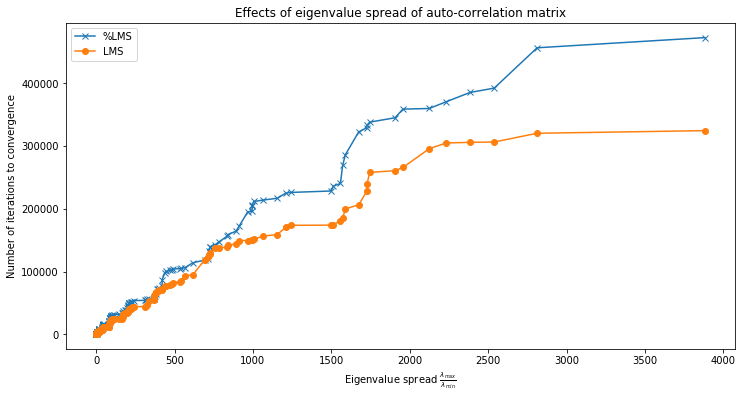

In [26]:
plt.figure(figsize=(12,6))
plt.plot(data['Eigenvalue spread'], data['%LMS'], 'x-', label='%LMS')
plt.plot(data['Eigenvalue spread'], data['LMS'], 'o-', label='LMS')
plt.title('Effects of eigenvalue spread of auto-correlation matrix')
plt.xlabel(r'Eigenvalue spread $\frac{\lambda_{max}}{\lambda_{min}}$')
plt.ylabel('Number of iterations to convergence')
plt.legend()
plt.savefig('eig_spread.png', dpi=200)

In [7]:
print(df.astype(np.int).to_latex(index=False, longtable=False))

\begin{tabular}{rrr}
\toprule
 Eigenvalue spread &     LMS &    \%LMS \\
\midrule
              1647 &  320427 &  237599 \\
              1153 &  102338 &  213806 \\
               435 &   71954 &   29265 \\
               136 &   46195 &   54949 \\
               109 &   18640 &   22129 \\
                43 &   11352 &   12823 \\
                20 &    4827 &    6917 \\
                 8 &    3408 &    3965 \\
                 3 &    1421 &    2189 \\
                 1 &     831 &     950 \\
\bottomrule
\end{tabular}



In [8]:
n_samples = 15000
a= 0.1
denom = [1, -a]

# Generate random input to do noise shaping with

v = np.sqrt(1-a**2) * np.random.randn(n_samples)

x = scipy.signal.lfilter([1], denom, v)

In [110]:
c = xcorr(x,x, maxlags=2)
c

array([   94.34280623,  1458.36397128, 15176.01758383,  1458.36397128,
          94.34280623])

array([1.01173451, 0.09722426])

In [94]:
len(c)

29999

In [182]:
a = np.logspace(-10, 0, 100)